# **SDG Prediction Validation**

## **Dependencies**

In [5]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Load Data**

### Load GIZ Project Data As Ground Truth

GIZ Running Projects can be used as ground truth for SDG.

In [6]:
running_giz_df = pd.read_excel("../../src/ground_truths/giz_running_projects.xlsx")

running_giz_df.head(1)

,*Projektnummer,"Projektbezeichnung, deutsch","Projektbezeichnung, englisch",CRS-Schlüssel,CRS-Bezeichnung,CRS-Gewichtung,2. CRS-Schlüssel,2. CRS-Bezeichnung,2. CRS-Gewichtung,3. CRS-Schlüssel,3. CRS-Bezeichnung,3. CRS-Gewichtung,4. CRS-Schlüssel,4. CRS-Bezeichnung,4. CRS-Gewichtung,SDG Hauptziele,"Projektziele, deutsch","Projektziele, englisch",BMZ-Schwerpunkt
0,2008.9076.4,Unterstützung bei der Einführung eines Kühlsch...,Refrigerator recycling system,41010.0,Umweltpolitik und -verwaltung,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13;15;,Unterstützung beim Aufbau eines beispielhaften...,Supporting the introduction of an exemplary ta...,"Umweltpolitik, Schutz und nachhaltige Nutzung ..."


### Load Merged DF

In [7]:
df = pd.read_csv("../../src/merged_orgas.csv")
df.head(1)

,iati_id,iati_orga_id,orga_abbreviation,orga_full_name,title_en,title_other,title_main,country_code_list,country,country_name,...,description_main,status,crs_5_code,crs_5_name,crs_3_code,crs_3_name,title_and_description,sgd_pred_code,sgd_pred_str,client
0,DE-1-201920016-0,DE-1,bmz,Bundesministerium für wirtschaftliche Zusammen...,Strengthening of Metrology for the Improvement...,Stärkung des Messwesens in Ägypten zur Verbess...,Strengthening of Metrology for the Improvement...,['AG'],AG;,Antigua and Barbuda,...,With a rapidly growing population and a promis...,Implementation,14010;,Water sector policy and administrative managem...,140;,Water Supply & Sanitation;,Strengthening of Metrology for the Improvement...,9,"8 9. Build resilient infrastructure, promot...",bmz


### Extract Project Numbers out of IATI ID

In [8]:
bmz_df = df[df.iati_orga_id == "DE-1"]

bmz_df["pn"] = "NaN"

for index, row in bmz_df.iterrows():
    try:
        pn_raw = row['iati_id'].split("-")[2]
        pn = f"{pn_raw[:4]}.{pn_raw[4:8]}.{pn_raw[8:]}"
        bmz_df.loc[index, "pn"] = pn
    except:
        pass

bmz_df.head(2)

C:\Users\UserNA6153\AppData\Local\Temp\ipykernel_21124\514410831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmz_df["pn"] = "NaN"


,iati_id,iati_orga_id,orga_abbreviation,orga_full_name,title_en,title_other,title_main,country_code_list,country,country_name,...,status,crs_5_code,crs_5_name,crs_3_code,crs_3_name,title_and_description,sgd_pred_code,sgd_pred_str,client,pn
0,DE-1-201920016-0,DE-1,bmz,Bundesministerium für wirtschaftliche Zusammen...,Strengthening of Metrology for the Improvement...,Stärkung des Messwesens in Ägypten zur Verbess...,Strengthening of Metrology for the Improvement...,['AG'],AG;,Antigua and Barbuda,...,Implementation,14010;,Water sector policy and administrative managem...,140;,Water Supply & Sanitation;,Strengthening of Metrology for the Improvement...,9,"8 9. Build resilient infrastructure, promot...",bmz,2019.2001.6
1,DE-1-201721877-0,DE-1,bmz,Bundesministerium für wirtschaftliche Zusammen...,Strengthening regional integration and coopera...,Stärkung der regionalen Integration und Zusamm...,Strengthening regional integration and coopera...,NaN,NaN,NaN,...,Finalisation,33130;,Regional trade agreements (RTAs);,331;,Trade Policies & Regulations;,Strengthening regional integration and coopera...,9,"8 9. Build resilient infrastructure, promot...",bmz,2017.2187.7


### Extract running GIZ projects just with 1 sdg to achieve better compareability 

In [9]:
running_giz_df = running_giz_df[running_giz_df['SDG Hauptziele'].str.len() == 3]

print(f"{len(running_giz_df)} with 1 SDG")
running_giz_df.head(1)

521 with 1 SDG


,*Projektnummer,"Projektbezeichnung, deutsch","Projektbezeichnung, englisch",CRS-Schlüssel,CRS-Bezeichnung,CRS-Gewichtung,2. CRS-Schlüssel,2. CRS-Bezeichnung,2. CRS-Gewichtung,3. CRS-Schlüssel,3. CRS-Bezeichnung,3. CRS-Gewichtung,4. CRS-Schlüssel,4. CRS-Bezeichnung,4. CRS-Gewichtung,SDG Hauptziele,"Projektziele, deutsch","Projektziele, englisch",BMZ-Schwerpunkt
1,2010.9226.1,GIZ Mgmt - Vertrag 1 - Unterstützung des BMU ...,GIZ Mgmt - Vertrag 1 - Unterstützung des BMU b...,99810.0,Nicht spezifizierte Sektoren (fortgeführt als ...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17;,EU Twinning,EU Twinning,Gestaltungsspielraum


### Match all running giz projects with IATI BMZ data 

In [10]:
# rename project number column in running_giz_df
running_giz_df.rename(columns={'*Projektnummer': 'pn'}, inplace=True)
running_giz_df.head(1)

,pn,"Projektbezeichnung, deutsch","Projektbezeichnung, englisch",CRS-Schlüssel,CRS-Bezeichnung,CRS-Gewichtung,2. CRS-Schlüssel,2. CRS-Bezeichnung,2. CRS-Gewichtung,3. CRS-Schlüssel,3. CRS-Bezeichnung,3. CRS-Gewichtung,4. CRS-Schlüssel,4. CRS-Bezeichnung,4. CRS-Gewichtung,SDG Hauptziele,"Projektziele, deutsch","Projektziele, englisch",BMZ-Schwerpunkt
1,2010.9226.1,GIZ Mgmt - Vertrag 1 - Unterstützung des BMU ...,GIZ Mgmt - Vertrag 1 - Unterstützung des BMU b...,99810.0,Nicht spezifizierte Sektoren (fortgeführt als ...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17;,EU Twinning,EU Twinning,Gestaltungsspielraum


In [11]:
# match with project number
merged_df = pd.merge(running_giz_df, bmz_df[["iati_id", "pn", "title_en", "description_main", "sgd_pred_code"]], on="pn", how="inner")
merged_df.dropna(subset=["sgd_pred_code"], inplace=True)
print(f"{len(merged_df)}")
merged_df.head(2)

388


,pn,"Projektbezeichnung, deutsch","Projektbezeichnung, englisch",CRS-Schlüssel,CRS-Bezeichnung,CRS-Gewichtung,2. CRS-Schlüssel,2. CRS-Bezeichnung,2. CRS-Gewichtung,3. CRS-Schlüssel,...,4. CRS-Bezeichnung,4. CRS-Gewichtung,SDG Hauptziele,"Projektziele, deutsch","Projektziele, englisch",BMZ-Schwerpunkt,iati_id,title_en,description_main,sgd_pred_code
0,2014.0968.9,Globalvorhaben Ernährungssicherung und Resilie...,"Global programme Food and Nutrition Security, ...",43072.0,Programme zur Ernährungssicherung auf Haushalt...,0.7,43071.0,Politiken/Verwaltungsführung zur Ernährungssic...,0.3,NaN,...,NaN,NaN,02;,Die Ernährungssituation und die Resilienz gege...,The food situation and the resilience to hunge...,"Sicherung der Ernährung, Landwirtschaft",DE-1-201409689,"Global programme Food and Nutrition Security, ...",The food situation and the resilience to hunge...,2
1,2014.2267.4,Modernisierung kommunaler Dienstleistungen,Modernization of Local Public Services,43030.0,Stadtentwicklung und -verwaltung,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,11;,In ländlichen Gemeinden werden kommunale Diens...,Efficient and sustainable provision of local p...,"Demokratie, Zivilgesellschaft, und öffentliche...",DE-1-201422674,Modernization of Local Public Services,Efficient and sustainable provision of local p...,11


In [12]:
# just use most important columns
analy_df = merged_df[["pn", "Projektbezeichnung, deutsch", "title_en", "SDG Hauptziele", "sgd_pred_code"]]
analy_df.head(400)

,pn,"Projektbezeichnung, deutsch",title_en,SDG Hauptziele,sgd_pred_code
0,2014.0968.9,Globalvorhaben Ernährungssicherung und Resilie...,"Global programme Food and Nutrition Security, ...",02;,2
1,2014.2267.4,Modernisierung kommunaler Dienstleistungen,Modernization of Local Public Services,11;,11
2,2014.2456.3,Beschäftigung für nachhaltige Wirtschaftentwic...,Employment and Skills for Development in Africa,08;,8
3,2014.4064.3,Verbesserung des Lernumfelds an öffentlichen S...,Improved Learning Environments at Public Schoo...,04;,4
4,2014.4065.0,Förderung partizipativen Ressourcenmanagements...,Supporting participatory Resource Management t...,06;,6
...,...,...,...,...,...
383,2023.4047.9,Sektorvorhaben Flucht,Sector Project Displacement,16;,11
384,2023.4064.4,Verbesserter Umgang mit Binnenmigration im Kon...,Improved management of internal migration in t...,10;,13
385,2023.4065.1,Qualifizierung und Beschäftigungsperspektiven ...,Qualification and Employment Prospects for Ref...,04;,8
386,2023.4070.1,"Beschäftigungsperspektiven für Flüchtlinge, Bi...","Employment Perspectives for Refugees, IDPs and...",08;,8


In [13]:
# change dtype that both cols can be compared
analy_df["SDG Hauptziele"] = analy_df["SDG Hauptziele"].str[:2].astype(int).astype(str)
analy_df["sgd_pred_code"] = analy_df["sgd_pred_code"].astype(str)
analy_df.head()

C:\Users\UserNA6153\AppData\Local\Temp\ipykernel_21124\2412280322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analy_df["SDG Hauptziele"] = analy_df["SDG Hauptziele"].str[:2].astype(int).astype(str)
C:\Users\UserNA6153\AppData\Local\Temp\ipykernel_21124\2412280322.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analy_df["sgd_pred_code"] = analy_df["sgd_pred_code"].astype(str)


,pn,"Projektbezeichnung, deutsch",title_en,SDG Hauptziele,sgd_pred_code
0,2014.0968.9,Globalvorhaben Ernährungssicherung und Resilie...,"Global programme Food and Nutrition Security, ...",2,2
1,2014.2267.4,Modernisierung kommunaler Dienstleistungen,Modernization of Local Public Services,11,11
2,2014.2456.3,Beschäftigung für nachhaltige Wirtschaftentwic...,Employment and Skills for Development in Africa,8,8
3,2014.4064.3,Verbesserung des Lernumfelds an öffentlichen S...,Improved Learning Environments at Public Schoo...,4,4
4,2014.4065.0,Förderung partizipativen Ressourcenmanagements...,Supporting participatory Resource Management t...,6,6


## **Analysis**

### Compare ground truth with predicted

In [14]:
sdg_labels = [str(i) for i in range(1, 17)]

cm = confusion_matrix(y_true = analy_df['SDG Hauptziele'], 
                    y_pred = analy_df['sgd_pred_code'], 
                    labels = sdg_labels)

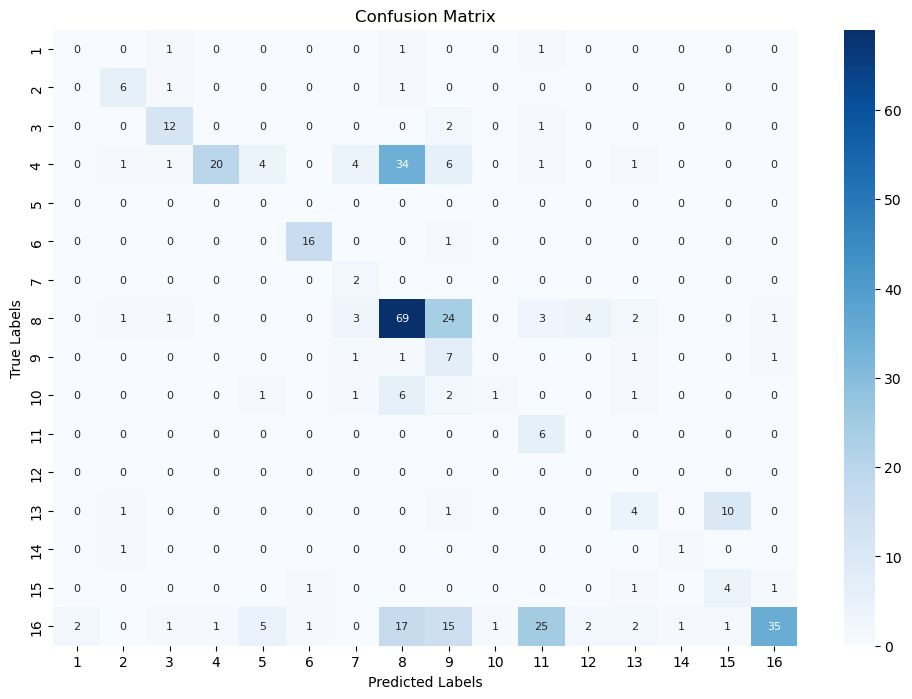

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, fmt='d', cmap='Blues', xticklabels=sdg_labels, yticklabels=sdg_labels, annot=True, annot_kws={"size": 8})

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()